 # Heart Disease

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

In [2]:
%matplotlib inline

## Decision Tree

In [3]:
class decision_tree():
    class __rule():
        def __init__(self, col, val):
            """
            A rule of a node of decision tree

            Args:
                col: column that defines the rule
                val: value that defines the rule
            """
            self.__col = col
            self.__val = val

        
        def is_satisfied(self, data):
            """
                Checks whether rule is satisfied given a data point

                Args:
                    data: data point of shape 1xm

            Returns:
                bool - whether rule is satisfied or not
            """
            if self.__col == None and self.__val == None:
                return True
            
            return data[0, self.__col] == self.__val
        
        def __str__(self):
            """
                Returns rule as a string
            """
            return f"col: {self.__col}, val: {self.__val}"


    def __init__(self, data, n_groups=3, max_depth=5, indexes="all", cols_exclude=[], rule=None, groups=[]):
        """
        Decision Tree

        Args:
            data:        tupple containing x of shape nxm and y of shape kxm
            n_groups:    number of groups to get after discretization of the input data
            max_depth:   maximum depth of the tree
            indexes:     indexes of the data that are associated with the decision tree. Either "all" or a numpy array of shape n
            cols_exlude: columns that are excluded
            rule:        rule that defines the decision tree
            groups:      maximum values of the data points to be included in the ith group
        """
        self.__rule_        = rule
        self.__max_depth    = max_depth
        self.__data         = data
        self.__branches     = []
        self.__cols_exclude = cols_exclude
        self.__n_groups     = n_groups
        self.__groups       = groups

        if isinstance(indexes, str) and indexes == "all":
            self.__indexes = np.ones(len(data[0]), dtype=bool)
        else:
            self.__indexes = indexes.copy()

        self.float_to_one_hot()
        
        if max_depth > 0:
            self.__branches = self.__branch()

    
    def get_rule(self):
        """
        Returns the rule that defines the decision tree
        """
        return self.__rule_

    
    def get_data(self):
        return self.__data

    
    def get_groups(self):
        return self.__groups


    def float_to_one_hot(self, data=[]):
        """
        Encodes float data as one-hot

        Args:
            data: numpy array of shape nxm 

        Returns:
            one-hot encoded numpy array
        """
        if len(data) == 0:
            if len(self.__groups) != 0:
                return self.__data[0], self.__groups
            data = self.__data[0].copy()
            groups = np.zeros((self.__data[0].shape[1], self.__n_groups))

            for col in range(data.shape[1]):
                data = data[data[:, col].argsort()]
                for i in range(self.__n_groups):
                    cur_val = data[(i + 1) * data.shape[0] // self.__n_groups - 1, col]
                    groups[col, i] = cur_val

            new_d = np.empty(data.shape)
            
            for col in range(groups.shape[0]):
                for i in range(groups.shape[1]):
                    if i == 0:
                        new_d[:, col][self.__data[0][:, col] <= groups[col, i]] = i
                    else:
                        new_d[:, col][(self.__data[0][:, col] <= groups[col, i]) & (self.__data[0][:, col] > groups[col, i - 1])] = i
                new_d[:, col][self.__data[0][:, col] > groups[col, -1]] = self.__n_groups - 1

            self.__groups = groups.copy()
            self.__data = (new_d.copy(), self.__data[1])

        else:
            groups = self.__groups
            new_d = np.empty(data.shape)
            for col in range(groups.shape[0]):
                for i in range(groups.shape[1]):
                    if i == 0:
                        new_d[:, col][data[:, col] <= groups[col, i]] = i
                    else:
                        new_d[:, col][(data[:, col] <= groups[col, i]) & (data[:, col] > groups[col, i - 1])] = i
                new_d[:, col][data[:, col] > groups[col, -1]] = self.__n_groups - 1

        return new_d, groups


    def __branch(self):
        """
        Creates a new branch based on discriminative power of columns

        Returns:
            new decision tree
        """
        if len(np.unique(self.__data[1][self.__indexes])) <= 1:
            return []

        branches     = []
        disc_max     = -np.inf
        disc_max_col = None

        for col in range(self.__data[0].shape[1]):
            if col in self.__cols_exclude:
                continue
            disc = self.disc(col)
            if disc > disc_max:
                disc_max     = disc
                disc_max_col = col

        if disc_max_col == None:
            return branches
            
        uniques = np.unique(self.__data[0][self.__indexes, disc_max_col])
        cols_exclude = [col for col in self.__cols_exclude]
        cols_exclude.append(disc_max_col)
        for unique in uniques:
            indexes = (self.__data[0][:, disc_max_col] == unique)
            indexes = np.logical_and(self.__indexes, indexes)
            rule = self.__rule(disc_max_col, unique)
            branches.append(decision_tree(self.__data, self.__n_groups, self.__max_depth - 1, indexes, cols_exclude, rule, self.__groups))
            
        return branches
    

    def entropy(self, col=None):
        """
        Calculates entropy of a dataset based on column and value or the dataset itself

        Args:
            col: column to determine the entropy of. Calculates entropy of the dataset by default

        Returns:
            entropy as float
        """

        res = 0
        if col == None:
            uniques, counts = np.unique(self.__data[1][self.__indexes], return_counts=True)
            for val, count in zip(uniques, counts):
                if len(self.__data[1][self.__indexes] == val) != 0:
                    res -= (count / len(self.__data[1][self.__indexes]) * np.log2(count / len(self.__data[1][self.__indexes])))
        else:
            uniques_y = np.unique(self.__data[1][self.__indexes], return_counts=True)
            uniques_x, counts_x = np.unique(self.__data[0][self.__indexes, col], return_counts=True)
            for unique_x, count_x in zip(uniques_x, counts_x):
                y_indexes = np.logical_and(self.__indexes, (self.__data[0][:, col].reshape(-1) == [unique_x]))
                e = 0
                for unique_y in uniques_y:
                    y = self.__data[1][np.logical_and(y_indexes, (self.__data[1].reshape(-1) == [unique_y]))]
                    if len(y) != 0:
                        e += len(y) / count_x * np.log2(len(y) / count_x) 

                res -= (count_x / len(self.__indexes) * e)
        return res

    
    def disc(self, col):
        """
        Calculates discriminative power of the variable

        Args:
            col: the column to calculate the discriminative power of

        Returns:
            discriminative power as float
        """
        res = self.entropy() - self.entropy(col)

        return res

    
    def __predict(self, data_x):
        """
        Predicts the class of a data point

        Args:
            data_x: a data point of shape 1xm

        Returns:
            name of class
        """
        if len(self.__branches) == 0:
            vals, counts = np.unique(self.__data[1][self.__indexes], return_counts=True)
            return vals[np.argmax(counts)]
        else:
            corresponding_branch = None
            for branch in self.__branches:
                if branch.get_rule().is_satisfied(data_x):
                    corresponding_branch = branch
                    break
            if corresponding_branch == None:
                # No such data point was detected before
                unique, counts = np.unique(self.__data[1], return_counts=True)
                return unique[np.argmax(counts)]
            return corresponding_branch.__predict(data_x)

    
    def predict(self, data_x):
        """
        Predicts the class of data

        Args:
            data_x: data of shape nxm

        Returns:
            numpy array of shape nx1 containing classes
        """

        results = np.empty((data_x.shape[0], 1), dtype=self.__data[1].dtype)
        data = data_x.copy()

        data, _ = self.float_to_one_hot(data)

        for i, dp in enumerate(data):
            results[i, 0] = self.__predict(dp.reshape(1, -1))
        
        return results


def float_to_one_hot(data, cols="all", classes_n=3):
    if cols != "all" and not isinstance(cols, list):
        raise AssertionError("cols must be either \"all\" or a list of names of columns")
    if cols == "all":
        cols = [col for col in range(data.shape[1])]
    data = data.copy()
    for col in cols:
        data = data[data[:, col].argsort()]
        for cl in range(classes_n):
            data[cl * len(data) // classes_n : (cl + 1) * len(data) // classes_n, col] = cl
    return data


def str_to_one_hot(data, cols=[-1]):
    """
    Encodes string data as one-hot

    Args:
        data: numpy array of shape nxm 
        cols: "all" or list of columns

    Returns:
        one-hot encoded numpy array
    """
    if cols != "all" and not isinstance(cols, list):
        raise AssertionError("cols must be either \"all\" or a list of names of columns")
    if cols == "all":
        cols = [col for col in data.columns]
    data = data.copy()
    dictionary = np.unique(data[:, cols])
    for col1 in cols:
        for i, col2 in enumerate(dictionary):
            data[data[:, col1] == col2, col1] = i
    return data, dictionary

## MLP

In [4]:
def sigmoid(x, derivative=False):
    """
    Args:
        x: array_like
        derivative: bool to specify whether to calculate derivative or not

    Returns:
        numpy array of sigmoid of x
    """
    return 1. / (1. + np.exp(-x)) if not derivative else x * (1. - x)


class Dense:
    def __init__(self, nodes, func=sigmoid):
        """
        Args:
            nodes: array_like. Number of neurons in each layer
            func: activation funcion
            
        Returns:
            Dense object
        """
        self.__func = func
        self.__nodes = np.array(nodes)

        self.__neurons = [np.empty([node, 1]) for node in nodes]
        self.__weights = [np.random.uniform(-.0001, .0001, [nodes[i + 1], nodes[i]]) for i in range(len(nodes) - 1)]
        self.__biases = [np.random.uniform( -.0001, .0001, [nodes[i + 1], 1])        for i in range(len(nodes) - 1)]

        self.__reset_deltas()

        
    def __reset_deltas(self):
        self.__delta_weights = [np.zeros([self.__nodes[i + 1], self.__nodes[i]]) for i in range(len(self.__nodes) - 1)]
        self.__delta_biases = [np.zeros([self.__nodes[i + 1], 1]) for i in range(len(self.__nodes) - 1)]
    
    
    def get_delta_weights(self):
        return self.__delta_weights
        
        
    def guess(self, x):
        """
        Args:
            x: 2d-array. Inputs of the network
            
        Returns:
            numpy array. Output of the network
        """
        output = np.empty([len(x), self.__nodes[-1]])
        for i, cur_input in enumerate(x):
            self.__neurons[0] = np.array(cur_input).reshape(-1, 1)
            for j in range(len(self.__neurons) - 1):
                self.__neurons[j + 1] = self.__func(self.__weights[j] @ self.__neurons[j] + self.__biases[j])

            output[i] = self.__neurons[-1].reshape(-1)
        return output
    
    
    def train(self, x, y, test=None, batch_size=128, epochs_num=1, lr=0.01, metrics=[]):
        """
        Args:
            x: 2d-array. Inputs of the network
            y: 2d-array. Expected outputs of the network
            batch_size: int. Number of inputs used during each training step
            epochs_num: int. Number of epochs
            lr: float. Learning rate of the training process
        Returns:
            history: dict of np.array
        """
        assert len(x) == len(y)
        
        if not test is None and not isinstance(test, tuple):
            raise AssertionError("test must be a tuple of test_x and test_y")
            
        if not test is None and len(test) != 2 or len(test[0]) != len(test[1]):
            raise AssertionError("test must be a tuple of test_x and test_y")
        
        if not test is None:
            history = dict()
            history["error"] = np.zeros([epochs_num])
            for i in range(len(metrics)):
                history[f"metric_{i}"] = np.zeros([epochs_num])
            
            test_x = test[0]
            test_y = test[1]
        
        for epoch in range(epochs_num):
            for step in range(len(x) // batch_size):
                self.__reset_deltas()
                for cur_input, cur_output in zip(x[batch_size * step: batch_size * (step + 1)], \
                                                 y[batch_size * step: batch_size * (step + 1)]):
                    self.__neurons[0] = np.array(cur_input).reshape(-1, 1)
                    for i in range(len(self.__neurons) - 1):
                        self.__neurons[i + 1] = self.__func(self.__weights[i] @ self.__neurons[i] + self.__biases[i])
                        
                    error = cur_output.reshape(-1, 1) - self.__neurons[-1]
                    grad = self.__func(self.__neurons[-1], True) * error
                    self.__delta_weights[-1] += (grad @ self.__neurons[-2].transpose())
                    self.__delta_biases[-1] += grad

                    for i in range(len(self.__nodes) - 3, -1, -1):
                        error = self.__weights[i + 1].transpose() @ error
                        grad = self.__func(self.__neurons[i + 1], True) * error
                        self.__delta_weights[i] += (grad @ self.__neurons[i].transpose())
                        self.__delta_biases[i] += grad
                        
                for i in range(len(self.__weights)):
                    self.__weights[i] += (self.__delta_weights[i] * lr / batch_size)
                    self.__biases[i] += (self.__delta_biases[i] * lr / batch_size)
                    
            if not test is None:
                pred = self.guess(test_x).reshape(-1, 1)
                history["error"][epoch] = np.mean((pred - test_y) ** 2)
                pred = np.round(pred)
                for i, metric in enumerate(metrics):
                    history[f"metric_{i}"][epoch] = metric(pred, test_y)
                if epoch > 10 and np.mean(history["error"][epoch - 9 : epoch + 1]) > history["error"][epoch - 9]:
                    history["error"] = history["error"][:epoch + 1]
                    for i, metric in enumerate(metrics):
                        history[f"metric_{i}"] = history[f"metric_{i}"][:epoch + 1]
                    return history
            
        return history

## Dataset

In [5]:
data = pd.read_csv("heart_disease_dataset.csv", delimiter=';')

data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
data.describe()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [7]:
np.sum(data.isnull())

age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
cholesterol                0
fasting_blood_sugar        0
rest_ecg                   0
max_heart_rate_achieved    0
exercise_induced_angina    0
st_depression              0
st_slope                   0
num_major_vessels          0
thalassemia                0
target                     0
dtype: int64

No null values in dataset

In [8]:
def mean(data):
    """
    Args:
        data: numpy array
    Returns:
        mean: numpy.float64, mean value of data
    """
    return np.sum(data.astype(float)) / len(data)


def std(data):
    """
    Args:
        data: numpy array
    Returns:
        std: numpy.float64, std of data
    """
    return np.sqrt((np.sum((data - mean(data)) ** 2)) / (len(data) - 1))
    

def covariance(data1, data2):
    """
    Args:
        data1, data2: numpy array
    Returns:
        covariance: numpy.float64
    """
    return mean((data1 - mean(data1)) * (data2 - mean(data2)))


def correlation(data1, data2):
    """
    Args:
        data1, data2: numpy array
    Returns:
        covariance: numpy.float64
    """
    return covariance(data1, data2) / (std(data1) * std(data2))

In [9]:
corr = np.empty([len(data.columns), len(data.columns)])

for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        corr[i, j] = correlation(data[col1], data[col2])

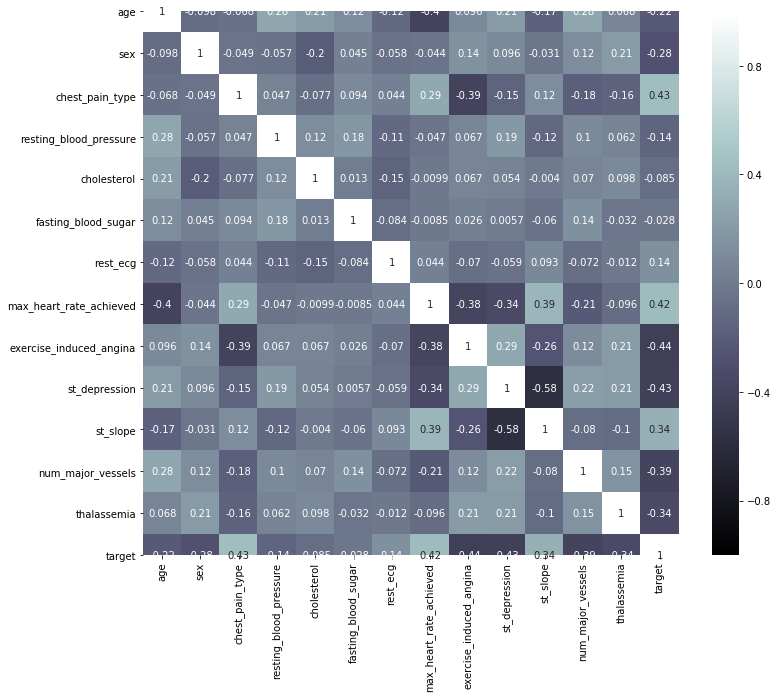

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

sns.heatmap(corr, 
            xticklabels=data.columns.values,
            yticklabels=data.columns.values,
            ax=ax,
            vmin=-1,
            vmax=1,
            annot=True,
            cmap="bone")

**target** mostly correlates with **exercise_induced_angina**, **st_depression**, **chest_pain_type**, **max_heart_rate_achived**

## Data splitting

In [11]:
def split_train_test(data, train_size=0.7):
    """
    Args:
        data: numpy array
        train_size=0.7: float, between 0 and 1, represents percentage of data to split into train samples
    Retruns:
        split: tupple of train and test datasets
    """
    indexes = np.random.permutation(len(data))

    train = data[indexes[:int(len(data) * train_size)]]
    test  = data[indexes[ int(len(data) * train_size):]]

    return (train, test)

## Preprocessing

In [12]:
def normalize(data, min=None, max=None):
    """
    Args:
        data: numpy.array
        min=None, max=None: float, by default min and max of data respectively
    Returns:
        (normalized_data, min, max)
        normalized_data: numpy.array
        min, max: numpy.float64
    """
    if min is None:
        min = np.min(data)
    if max is None:
        max = np.max(data)
    return (data - min) / (max - min), min, max


def standardize(data, s=None, m=None):
    """
    Args:
        data: numpy.array
        s=None: float, standard deviation of the data by default
        m=None: float, mean value of the data by default
    Returns:
        (normalized_data, s, m)
        normalized_data: numpy.array
        s, m: numpy.float64
    """
    if s is None:
        s = std(data)
    if m is None:
        m = mean(data)
    return (data - m) / s, s, m


def to_one_hot(data, cols):
    """
    Args:
        data: Pandas Dataframe
        cols: list, columns of data to encode
    Returns:
        data: Pandas Dataframe containing one hot encoded data
    """
    res = data.copy()
    res = res.drop(columns=cols)
    for col in cols:
        dummies = pd.get_dummies(data[col], prefix=col)
        res = pd.concat([res, dummies], axis=1)
    return res

## Metrics

In [13]:
def confusion_matrix(y_pred, y_true):
    """
    Args:
        y_pred, y_true: nx1 np.array
    Returns:
        confusion_matrix: numpy.array of shape 4, (tp, fp, fn, tn)
    """
    if not isinstance(y_pred, np.ndarray) or not isinstance(y_true, np.ndarray):
        raise AssertionError("y_pred and y_true must be of type numpy.array")
        
    if y_pred.shape != y_true.shape:
        raise AssertionError("y_pred and y_true must be of same shape")
        
    result = [0, 0, 0, 0]
    
    for i in range(len(y_pred)):
        if   y_pred[i] == 1 and y_true[i] == 1:
            result[0] += 1
        elif y_pred[i] == 0 and y_true[i] == 1:
            result[2] += 1
        elif y_pred[i] == 1 and y_true[i] == 0:
            result[1] += 1
        else:
            result[3] += 1
    
    return np.array(result)


def precision(y_pred, y_true):
    """
    Args:
        y_pred, y_true: nx1 np.array
    Returns:
        precision: numpy.float64
    """
    if not isinstance(y_pred, np.ndarray) or not isinstance(y_true, np.ndarray):
        raise AssertionError("y_pred and y_true must be of type numpy.array")
        
    if y_pred.shape != y_true.shape:
        raise AssertionError("y_pred and y_true must be of same shape")
        
    tp, fp, fn, tn = confusion_matrix(y_pred, y_true)
    return tp / (tp + fp)


def recall(y_pred, y_true):
    """
    Args:
        y_pred, y_true: nx1 np.array
    Returns:
        recall: numpy.float64
    """
    if not isinstance(y_pred, np.ndarray) or not isinstance(y_true, np.ndarray):
        raise AssertionError("y_pred and y_true must be of type numpy.array")
        
    if y_pred.shape != y_true.shape:
        raise AssertionError("y_pred and y_true must be of same shape")
        
    tp, fp, fn, tn = confusion_matrix(y_pred, y_true)
    return tp / (tp + fn)


def accuracy(y_pred, y_true):
    """
    Args:
        y_pred, y_true: nx1 np.array
    Returns:
        accuracy: numpy.float64
    """
    if not isinstance(y_pred, np.ndarray) or not isinstance(y_true, np.ndarray):
        raise AssertionError("y_pred and y_true must be of type numpy.array")
        
    if y_pred.shape != y_true.shape:
        raise AssertionError("y_pred and y_true must be of same shape")
        
    tp, fp, fn, tn = confusion_matrix(y_pred, y_true)
    return (tp + tn) / (tp + fp + fn + tn)


def specificity(y_pred, y_true):
    """
    Args:
        y_pred, y_true: nx1 np.array
    Returns:
        specificity: numpy.float64
    """
    if not isinstance(y_pred, np.ndarray) or not isinstance(y_true, np.ndarray):
        raise AssertionError("y_pred and y_true must be of type numpy.array")
        
    if y_pred.shape != y_true.shape:
        raise AssertionError("y_pred and y_true must be of same shape")
        
    tp, fp, fn, tn = confusion_matrix(y_pred, y_true)
    return tn / (fp + tn)


def f1_score(y_pred, y_true):
    """
    Args:
        y_pred, y_true: nx1 np.array
    Returns:
        f1_score: numpy.float64
    """
    if not isinstance(y_pred, np.ndarray) or not isinstance(y_true, np.ndarray):
        raise AssertionError("y_pred and y_true must be of type numpy.array")
        
    if y_pred.shape != y_true.shape:
        raise AssertionError("y_pred and y_true must be of same shape")
        
    tp, fp, fn, tn = confusion_matrix(y_pred, y_true)
    return 2 * tp / (2 * tp + fp + fn)

## Decision Tree

In [14]:
train, test = split_train_test(data.values, 0.5)

In [15]:
x_cols  = list(range(len(data.columns) - 1))
train_x = train[:, x_cols]
test_x  = test [:, x_cols]

y_cols  = [-1]
train_y = train[:, y_cols]
test_y  = test [:, y_cols]

In [16]:
n_groups = 3
dt = decision_tree((train_x, train_y), n_groups=n_groups, max_depth=4)

print(f"Training on {len(train_x)} data points, validating on {len(test_x)} data points, n_groups: {n_groups}")

pred = dt.predict(test_x)

print(f"Accuracy   : {accuracy(pred, test_y)}")
print(f"Precision  : {precision(pred, test_y)}")
print(f"Recall     : {recall(pred, test_y)}")
print(f"Specificity: {specificity(pred, test_y)}")
print(f"F1 score   : {f1_score(pred, test_y)}")

Training on 151 data points, validating on 152 data points, n_groups: 3
Accuracy   : 0.7039473684210527
Precision  : 0.8088235294117647
Recall     : 0.632183908045977
Specificity: 0.8
F1 score   : 0.7096774193548387


/home/agayev169/.local/lib/python3.6/site-packages/ipykernel_launcher.py:194: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


## MLP

In [17]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [18]:
one_hot_cols = ["sex", "chest_pain_type", "rest_ecg", "exercise_induced_angina", 
                "st_slope", "num_major_vessels", "thalassemia"]

data_one_hot = to_one_hot(data, cols=["sex", "chest_pain_type", "rest_ecg", 
                                      "exercise_induced_angina", "st_slope", 
                                      "num_major_vessels", "thalassemia"])
data_one_hot = data_one_hot[[c for c in data_one_hot if c != "target"] + ["target"]]
data_one_hot.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,st_depression,sex_0,sex_1,chest_pain_type_0,chest_pain_type_1,...,num_major_vessels_0,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,num_major_vessels_4,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_3,target
0,63,145,233,1,150,2.3,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
1,37,130,250,0,187,3.5,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
2,41,130,204,0,172,1.4,1,0,0,1,...,1,0,0,0,0,0,0,1,0,1
3,56,120,236,0,178,0.8,0,1,0,1,...,1,0,0,0,0,0,0,1,0,1
4,57,120,354,0,163,0.6,1,0,1,0,...,1,0,0,0,0,0,0,1,0,1


In [19]:
one_hot_cols = ["sex_0", "sex_1", "chest_pain_type_0", 
                "chest_pain_type_1", "chest_pain_type_2", 
                "chest_pain_type_3", "rest_ecg_0", "rest_ecg_1", 
                "rest_ecg_2", "exercise_induced_angina_0", 
                "exercise_induced_angina_1", "st_slope_0", 
                "st_slope_1", "st_slope_2", "num_major_vessels_0", 
                "num_major_vessels_1", "num_major_vessels_2", 
                "num_major_vessels_3", "num_major_vessels_4", 
                "thalassemia_0", "thalassemia_1", 
                "thalassemia_2", "thalassemia_3"]

In [40]:
train, test = split_train_test(data_one_hot.values, 0.5)
train_x = train[:, :-1]
train_y = train[:,  -1].reshape(-1, 1)

test_x  = test[:, :-1]
test_y  = test[:,  -1].reshape(-1, 1)

for i in range(train_x.shape[1]):
    if data_one_hot.columns[i] in one_hot_cols:
        continue
    train_x[:, i], s, m = standardize(train_x[:, i])
    test_x [:, i], _, _ = standardize(test_x [:, i], s, m)

In [41]:
%%time

nn = Dense([train_x.shape[1], 5, 1])
history = nn.train(train_x, train_y, (test_x, test_y), batch_size=4, epochs_num=4000, lr=0.01, 
                   metrics=[accuracy, precision, recall, specificity, f1_score])

CPU times: user 13.2 s, sys: 10.8 ms, total: 13.2 s
Wall time: 13.2 s


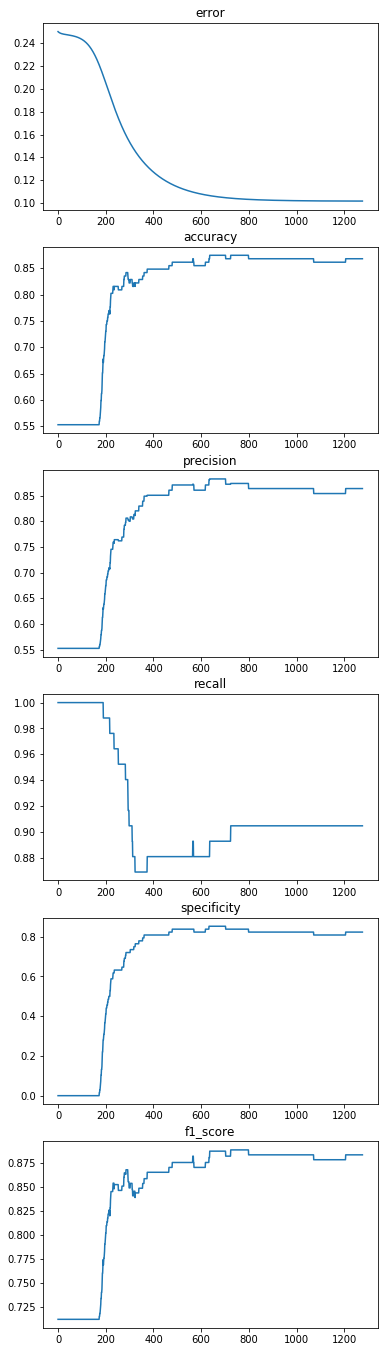

In [42]:
fig, ax = plt.subplots(6, 1, figsize=(6, 24))
keys = ["error", "accuracy", "precision", "recall", "specificity", "f1_score"]
for i, key in enumerate(history.keys()):
    ax[i].plot(history[key])
    ax[i].set_title(keys[i])

(-0.5, 1.5)

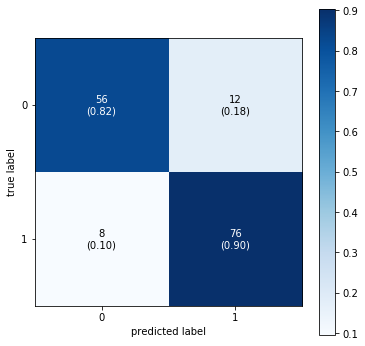

In [43]:
pred = np.round(nn.guess(test_x)).reshape(-1, 1)
tp, fp, fn, tn = confusion_matrix(pred, test_y)
cm = np.array([[tn, fp], [fn, tp]])

fig, ax = plot_confusion_matrix(cm, 
                                figsize=(6, 6),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
ax.set_xlim()

In [44]:
pred = np.round(nn.guess(test_x))

print(f"Accuracy   : {accuracy(pred, test_y)}")
print(f"Precision  : {precision(pred, test_y)}")
print(f"Recall     : {recall(pred, test_y)}")
print(f"Specificity: {specificity(pred, test_y)}")
print(f"F1 score   : {f1_score(pred, test_y)}")
print(f"MSE        : {history['error'][-1]}")

Accuracy   : 0.868421052631579
Precision  : 0.8636363636363636
Recall     : 0.9047619047619048
Specificity: 0.8235294117647058
F1 score   : 0.8837209302325582
MSE        : 0.10192428056368186
